In [110]:
import numpy as np
import numpy.random as rd
import jax
from jax import numpy as jnp
from jax.numpy import linalg as jla
import matplotlib.pyplot as plt
from env.mdp import MarkovDecisionProcess,Sampler
from env.gridworld import Gridworld, gridplot
from env.complete import Complete
from algs.projs import euclidean_l1ball, euclidean_simplex, euclidian_pos_orthant
from algs.lps import unregCMDPLP
from typing import Tuple
from itertools import accumulate
from einops import rearrange
Point = Tuple[int,int]
Goal = Tuple[Point,float]

def flatten(v):
    return jnp.reshape(v,(list(accumulate(v.shape,lambda x,y:x*y))[-1],))

### Solving unregularized CMDPS with the LP formulation

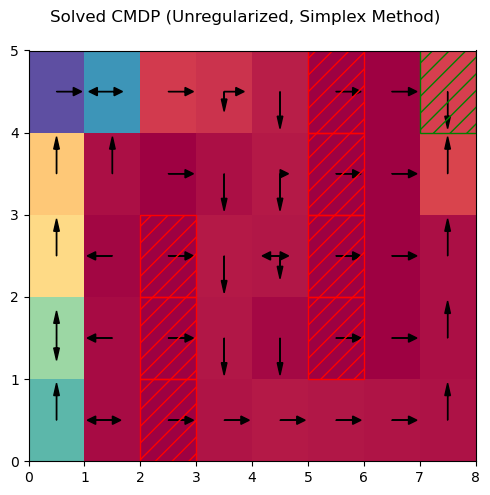

In [2]:
goals = [((7,4),100)]
obstacles = [(2,0),(2,1),(2,2),(5,1),(5,2),(5,3),(5,4)]
gridMDP = Gridworld(8,5,0.1,0.9,goals=goals,obstacles=obstacles) #build a "wall of obstacles"
gridMDP.Psi = gridMDP.Psi*1000
solver = unregCMDPLP(gridMDP)
mu = solver.solve()
sz = 5.
mu_s = np.sum(mu,axis=1)
fig, ax = plt.subplots(1,1,figsize=(sz,sz))
plot = np.average(gridMDP.states2grid(mu),axis=2)
gridplot(gridMDP,ax,mu_s,stochastic_policy=solver.recover_stochastic_policy(),obstacles=obstacles,goals=goals)
fig.suptitle('Solved CMDP (Unregularized, Simplex Method)')
fig.tight_layout()

[((0, 0), 2, 0), ((0, 1), 2, 0.0), ((0, 2), 2, 0.0), ((0, 3), 2, 0.0), ((0, 4), 0, 0.0), ((1, 4), 1, 0.0), ((0, 4), 0, 0.0), ((1, 4), 1, 0.0), ((0, 4), 0, 0.0), ((1, 4), 1, 0.0), ((0, 4), 0, 0.0), ((0, 3), 2, 0.0), ((0, 4), 0, 0.0), ((1, 4), 1, 0.0), ((0, 4), 0, 0.0), ((1, 4), 1, 0.0), ((0, 4), 0, 0.0), ((1, 4), 1, 0.0), ((0, 4), 0, 0.0), ((1, 4), 1, 0.0), ((0, 4), 0, 0.0), ((0, 4), 0, 0.0), ((0, 3), 2, 0.0), ((0, 4), 0, 0.0), ((1, 4), 1, 0.0), ((0, 4), 0, 0.0), ((1, 4), 1, 0.0), ((0, 4), 0, 0.0), ((0, 4), 0, 0.0), ((1, 4), 1, 0.0), ((0, 4), 0, 0.0), ((1, 4), 1, 0.0), ((0, 4), 0, 0.0), ((1, 4), 1, 0.0), ((0, 4), 0, 0.0), ((1, 4), 0, 0.0), ((2, 4), 0, 0.0), ((3, 4), 0, 0.0), ((4, 4), 3, 0.0), ((4, 3), 3, 0.0), ((4, 2), 3, 0.0), ((4, 1), 3, 0.0), ((4, 0), 0, 0.0), ((5, 0), 0, 0.0), ((6, 0), 0, 0.0), ((7, 0), 2, 0.0), ((7, 1), 2, 0.0), ((7, 2), 2, 0.0), ((7, 3), 2, 0.0), ((7, 4), 3, 0.0), ((7, 3), 2, 100.0), ((7, 4), 3, 0.0), ((7, 3), 2, 100.0), ((7, 4), 3, 0.0), ((7, 3), 2, 100.0), ((7, 

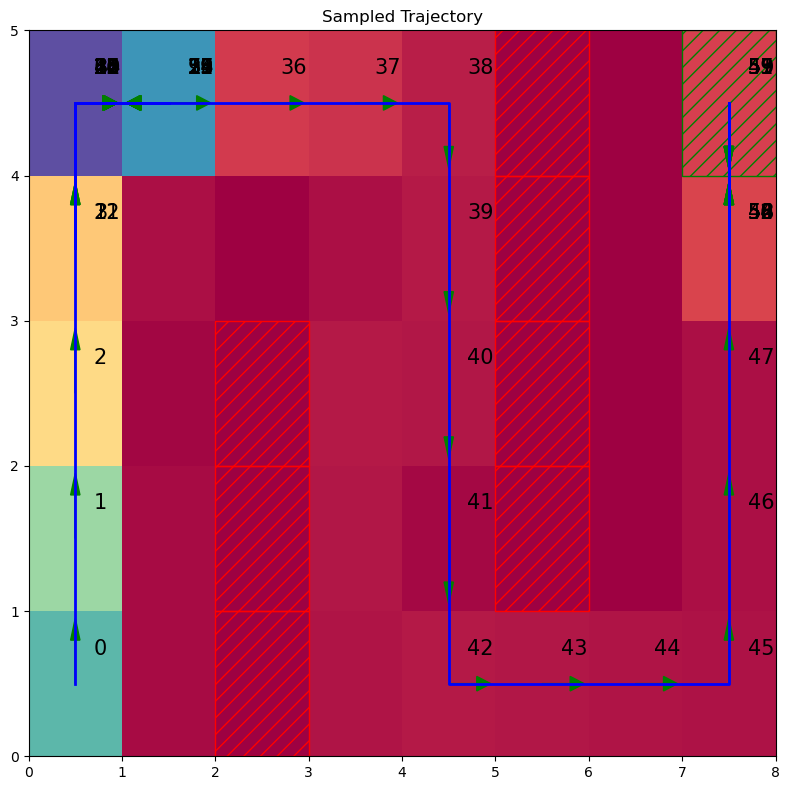

In [3]:
smp = Sampler(gridMDP)

""" Get the initial state """
traj = []
r_t = 0
s_t = smp.reset()
for i in range(60):
    a_t = rd.choice(np.arange(4), p = solver.recover_stochastic_policy()[s_t]) 
    traj += [(gridMDP.state2point(s_t),a_t,r_t)]
    s_t, r_t = smp.step(a_t)

traj


print(traj)
fig, ax = plt.subplots(1,1,figsize=(8,8))
gridplot(gridMDP, ax, scalar=mu_s, traj=traj, goals=goals, obstacles=obstacles)
ax.set_title('Sampled Trajectory')
fig.tight_layout()
plt.show()

### Constrained Bandits

In [84]:
n = 2
constraints = [
    [0,0.2,0.,0],
    [0,0.2,0.,0],]
def cost_matrix(a,c):
    return c[a]
b = np.ones((len(constraints)))*2.0
Psi = np.array(  
        [[[ cost_matrix(a,c) 
            for _  in range(1)             ] 
            for a  in range(n)             ] 
            for c  in constraints         ],dtype=np.float64) * 0.2

Bandit = Complete(1,n,1.,b=b,Psi=Psi,rmax=2.) # Bandits are just one state MDPs
Bandit.R = euclidean_l1ball(Bandit.R) # make sur reward is in reward class

### Reniy Entropy regularizer

Defined as : 
$$
H_\alpha(\pi) = \frac{\alpha}{1-\alpha} \cdot \log \| \pi \|_\alpha
$$

In [85]:
def renyi_h2(pi,alpha):
    return (alpha/(1-alpha)) * jnp.log(jla.norm(pi,alpha))

### Implementing a saddle-point forward RL solver

We want to solve the MDP by solving 
$$
\min_{\zeta \succcurlyeq 0} \max_{\pi \in  \Delta_a} r^T \pi + \beta H_2(\pi) - \zeta^T(b-\Psi \pi),
$$
where :
$$
\text{obj}(\pi,\zeta) = r^T \pi + \beta H_2(\pi) - \zeta^T(b-\Psi \pi).
$$

In [101]:
def obj(pi, zeta, r, beta, b, Psi):
    Psi_t = rearrange(Psi,'c a s -> (a s) c').transpose()
    return jnp.dot(flatten(r),flatten(pi)) \
        + beta * renyi_h2(flatten(pi),2) \
            - jnp.dot(flatten(zeta),flatten(b-(Psi_t@pi.transpose()).transpose()))

In [190]:
def eval_grads(pi,zeta,beta,Bandit):
    val = obj(pi,zeta,Bandit.R,beta,Bandit.b,Bandit.Psi)
    grad_zeta = jax.grad(obj,1)(pi,zeta,Bandit.R,beta,Bandit.b,Bandit.Psi)
    grad_pi = jax.grad(obj,0)(pi,zeta,Bandit.R,beta,Bandit.b,Bandit.Psi)
    return val, grad_pi, grad_zeta

eta = 1e-1  # set the learning rate
beta = 0.1  # set the value of the regularizer constant
zeta_t = rd.random(Bandit.b.shape) # initialize dual variable (for the constraints)
pi_t = euclidean_simplex(rd.random((1,n))) # initialize policy somewhere in the simplex
K = 30
vals = []
pis = []
zetas = []
normfs = []
for k in range(K):
    _, grad_pi, grad_zeta = eval_grads(pi_t,zeta_t,beta,Bandit)
    zeta_t_half = euclidian_pos_orthant( zeta_t-eta*grad_pi )
    pi_t_half = euclidean_simplex( pi_t+eta*grad_pi )
    val, grad_pi, grad_zeta = eval_grads(pi_t_half,zeta_t_half,beta,Bandit)
    zeta_t = euclidian_pos_orthant( zeta_t-eta*grad_pi )
    pi_t = euclidean_simplex( pi_t+eta*grad_pi )
    vals += [val]; pis += [pi_t]; zetas += [zeta_t]; normfs += [jla.norm(jnp.concatenate([eta*grad_pi,eta*grad_zeta],1),2)]

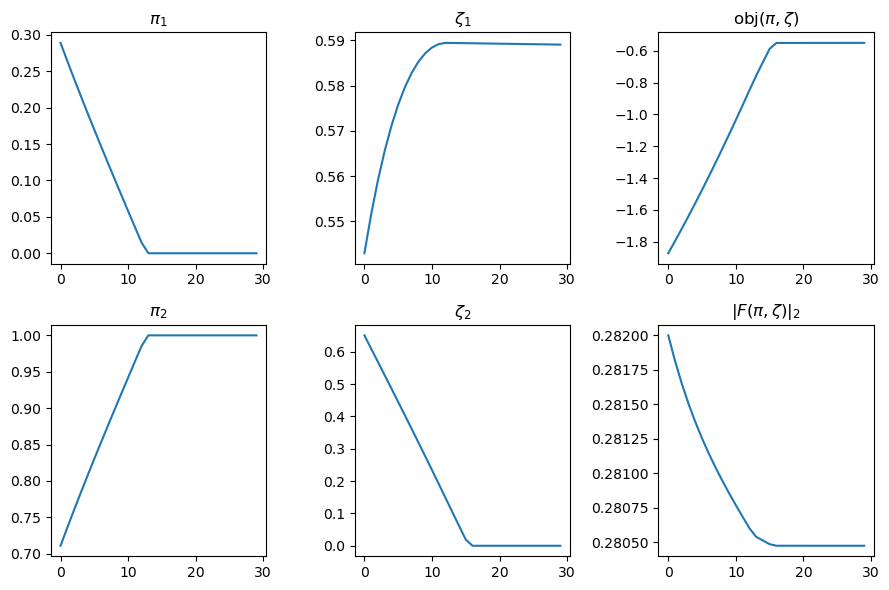

In [192]:
sz = 3
fig, ax = plt.subplots(2,3,figsize=(3*sz,2*sz))
ax[0,0].plot([i for i,_ in enumerate(vals)],[float(pi[0,0]) for pi in pis])
ax[0,0].set_title(r'$\pi_1$')
ax[1,0].plot([i for i,_ in enumerate(vals)],[float(pi[0,1]) for pi in pis])
ax[1,0].set_title(r'$\pi_2$')
ax[0,1].set_title(r'$\zeta_1$')
ax[0,1].plot([i for i,_ in enumerate(vals)],[float(zeta[0,0]) for zeta in zetas])
ax[1,1].plot([i for i,_ in enumerate(vals)],[float(zeta[0,1]) for zeta in zetas])
ax[1,1].set_title(r'$\zeta_2$')
ax[0,2].plot([i for i,_ in enumerate(vals)],np.array([float(v) for v in vals]))
ax[0,2].set_title(r'obj$(\pi,\zeta)$')
ax[1,2].plot([i for i,_ in enumerate(vals)],np.array([float(f) for f in normfs]))
ax[1,2].set_title(r'$\|F(\pi,\zeta)\|_2$')
fig.tight_layout()